***OpenAI Whisper***

In this project I will use OpenAI Whisper to transcribe data from Fed speech video and compare market market data during the time speech was live broadcasted. In order to analyze market reaction to specific words that Fed chair J.Powell says during the press conference.

First we need to download OpenAI Whisper Python package using pip.


In [2]:
!pip install git+https://github.com/openai/whisper.git -q


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


We'll also make sure we have a GPU available in Google Colab. If you don't have a GPU, go to Runtime -> Change Runtime Type -> Hardware Accelator and select GPU. I have Colab Pro so I get access to Premium GPU's. Run the command below to show which GPU is being used in the current runtime:

In [1]:
!nvidia-sml-

/bin/bash: line 1: nvidia-sml-: command not found


Whisper transcribes audio speech to text. To see this in action, we'll need some audio to operate on. We'll extract some audio from a YouTube video using the pytube Python package. let's install it with pip.



In [4]:
!pip install pytube -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.5 MB/s eta 0:00:00


Now we can import Whisper, and YouTube from pytube.

In [6]:
import whisper
from pytube import YouTube

OpenAI Whisper has a variety of model of different sizes. The larger the model the more accurate output is, however for this project base model will be sufficient.

In [9]:
model = whisper.load_model('base')

100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 90.0MiB/s]


We'll now instantiate a "YouTube" object by passing in the video URL. This will allow us to retrieve metadata and stream info about the specified YouTube URL.

In [10]:
youtube_video_url = "https://www.youtube.com/watch?v=NT2H9iyd-ms"
youtube_video = YouTube(youtube_video_url)

Now that we have pytube object, let's explore some of it's attributes.

In [11]:
youtube_video.title

'WATCH LIVE | Fed Chair Powell Discusses Latest Fed Rate Hike'

In order to see other metadata from youtube video you may use dir(youtube_video)

We can get a list of video and audio streams of varying quality. For this project we only need audio files.

In [12]:
youtube_video.streams

[<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">, <Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">, <Stream: itag="137" mime_type="video/mp4" res="1080p" fps="30fps" vcodec="avc1.640028" progressive="False" type="video">, <Stream: itag="248" mime_type="video/webm" res="1080p" fps="30fps" vcodec="vp9" progressive="False" type="video">, <Stream: itag="136" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001f" progressive="False" type="video">, <Stream: itag="247" mime_type="video/webm" res="720p" fps="30fps" vcodec="vp9" progressive="False" type="video">, <Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d401f" progressive="False" type="video">, <Stream: itag="244" mime_type="video/webm" res="480p" fps="30fps" vcodec="vp9" progressive="False" type="video">, <Stream: itag="1

In [13]:
for stream in youtube_video.streams:
  print(stream)

<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">
<Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">
<Stream: itag="137" mime_type="video/mp4" res="1080p" fps="30fps" vcodec="avc1.640028" progressive="False" type="video">
<Stream: itag="248" mime_type="video/webm" res="1080p" fps="30fps" vcodec="vp9" progressive="False" type="video">
<Stream: itag="136" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001f" progressive="False" type="video">
<Stream: itag="247" mime_type="video/webm" res="720p" fps="30fps" vcodec="vp9" progressive="False" type="video">
<Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d401f" progressive="False" type="video">
<Stream: itag="244" mime_type="video/webm" res="480p" fps="30fps" vcodec="vp9" progressive="False" type="video">
<Stream: itag="134" mime_

Lets filter and get rid of video streams, and leave only audio files

In [14]:
streams = youtube_video.streams.filter(only_audio=True)
streams

[<Stream: itag="139" mime_type="audio/mp4" abr="48kbps" acodec="mp4a.40.5" progressive="False" type="audio">, <Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2" progressive="False" type="audio">, <Stream: itag="249" mime_type="audio/webm" abr="50kbps" acodec="opus" progressive="False" type="audio">, <Stream: itag="250" mime_type="audio/webm" abr="70kbps" acodec="opus" progressive="False" type="audio">, <Stream: itag="251" mime_type="audio/webm" abr="160kbps" acodec="opus" progressive="False" type="audio">]

For this project we do not need highest quality audio, so we can choose first stream.

In [15]:
stream = streams.first()
stream

<Stream: itag="139" mime_type="audio/mp4" abr="48kbps" acodec="mp4a.40.5" progressive="False" type="audio">

OK, now we have a single stream that we will use. Let's download the stream as fed_meeting.mp4. You should see the file appear in the filesystem browser on the side panel of Colab. Click the refresh button if you don't see it after a while.

In [16]:
stream.download(filename='fed_meeting.mp4')

'/content/fed_meeting.mp4'

We can do some additional processing on the audio file should we choose. I want to ignore any additional sound and speech after Jerome Powell speaks. So we'll use ffmpeg to do this. The command will start the audio file at the 375 second mark where he starts with good afternoon, continue for 2715 seconds, and chop off the rest of the audio. The result will be saved in a new file called fed_meeting_trimmed.mp4.

In [17]:
!ffmpeg -ss 378 -i fed_meeting.mp4 -t 2715 fed_meeting_trimmed.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

It is possible to embed an audio player into Google Colab, but will not do this for now since I have seen the runtime get disconnected on large audio files. If you want a copy of the resulting audio, you can download it locally using the Colab the file browser.

Transcribing itself may take a while depending on your hardware. Next line of code will use datetime to get the duration of the transcription process. I have tested different combinations of CPU/GPU and models to see the difference in time it takes different models to accomplish the same task.

In [18]:
import datetime
# save the timestamps before transcription
t1 = datetime.datetime.now()
print(f"started at {t1}")

# do the transcription
output = model.transcribe('fed_meeting_trimmed.mp4')

#show time elapsed after transcription is complete.
t2 = datetime.datetime.now()
print(f"ended at {t2}")
print(f'time elapsed: {t2 - t1}')

started at 2024-04-25 09:13:44.514815


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


ended at 2024-04-25 09:30:22.075954
time elapsed: 0:16:37.561139


We can get output, that provides a lot of data. Such as text, word tokens and etc,

In [19]:
output

{'text': " Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2% goal. We have both the tools that we need and the resolve it will take to restore price stability on behalf of American families and businesses. Price stability is the responsibility of the Federal Reserve and serves as the bedrock of our economy. Without price stability, the economy does not work for anyone. In particular, without price stability, we will not achieve a sustained period of strong labor market conditions that benefit all. Today, the FOMC raised our policy interest rate by 75 basis points and we continue to anticipate that ongoing increases will be appropriate. We are moving our policy stance purposefully to a level that will be sufficiently restrictive to return inflation to 2%. In addition, we are continuing the process of significantly reducing the size of our balance sheet. Restoring price stability will likely require maintaining a restrictive stance of po

Now we can get only text

In [21]:
output['text']

" Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2% goal. We have both the tools that we need and the resolve it will take to restore price stability on behalf of American families and businesses. Price stability is the responsibility of the Federal Reserve and serves as the bedrock of our economy. Without price stability, the economy does not work for anyone. In particular, without price stability, we will not achieve a sustained period of strong labor market conditions that benefit all. Today, the FOMC raised our policy interest rate by 75 basis points and we continue to anticipate that ongoing increases will be appropriate. We are moving our policy stance purposefully to a level that will be sufficiently restrictive to return inflation to 2%. In addition, we are continuing the process of significantly reducing the size of our balance sheet. Restoring price stability will likely require maintaining a restrictive stance of policy for 

Let's loop through and get all the segments


In [22]:
for segment in output['segments']:
  print(segment)
  second = int(segment['start'])
  second = second - (second % 5)
  print(second)

{'id': 0, 'seek': 0, 'start': 0.0, 'end': 8.0, 'text': ' Good afternoon. My colleagues and I are strongly committed to bringing inflation back down to our 2% goal.', 'tokens': [50364, 2205, 6499, 13, 1222, 7734, 293, 286, 366, 10613, 7784, 281, 5062, 15860, 646, 760, 281, 527, 568, 4, 3387, 13, 50764], 'temperature': 0.0, 'avg_logprob': -0.1440796594362001, 'compression_ratio': 1.5818181818181818, 'no_speech_prob': 0.0640966072678566}
0
{'id': 1, 'seek': 0, 'start': 8.0, 'end': 16.0, 'text': ' We have both the tools that we need and the resolve it will take to restore price stability on behalf of American families and businesses.', 'tokens': [50764, 492, 362, 1293, 264, 3873, 300, 321, 643, 293, 264, 14151, 309, 486, 747, 281, 15227, 3218, 11826, 322, 9490, 295, 2665, 4466, 293, 6011, 13, 51164], 'temperature': 0.0, 'avg_logprob': -0.1440796594362001, 'compression_ratio': 1.5818181818181818, 'no_speech_prob': 0.0640966072678566}
5
{'id': 2, 'seek': 0, 'start': 16.0, 'end': 22.0, 'text'

Ok now we have successfully transcibe the audio from the YouTube video by using OpenAI Whisper. There are many implementations of this, however for this project I am going to compare Speech Data with Price Action during the live broadcast of the given speech.

***Combining Speech Data with Price Data***

I will use external data from Interactive Broker (a file named spy.csv), a code and file for that can be found in the same Github repository

In [23]:
import pandas as pd

In [25]:
spy = pd.read_csv("spy.csv")


In [26]:
spy

,date,open,high,low,close,volume,average,barCount
0,2022-11-02 14:31:15,387.13,387.17,386.75,386.83,82173.0,386.884,444
1,2022-11-02 14:31:20,386.80,387.00,386.80,386.91,38918.0,386.913,234
2,2022-11-02 14:31:25,386.94,386.96,386.55,386.64,48165.0,386.749,232
3,2022-11-02 14:31:30,386.64,386.95,386.59,386.86,30688.0,386.760,190
4,2022-11-02 14:31:35,386.91,386.92,386.81,386.87,22270.0,386.862,130
...,...,...,...,...,...,...,...,...
538,2022-11-02 15:16:05,380.30,380.48,380.30,380.39,40401.0,380.418,265
539,2022-11-02 15:16:10,380.37,380.49,380.24,380.45,40709.0,380.378,221
540,2022-11-02 15:16:15,380.45,380.48,380.38,380.39,12465.0,380.425,69
541,2022-11-02 15:16:20,380.38,380.38,380.28,380.36,24107.0,380.324,139


Since we already have the segments of the speech and their start and end times in seconds, we can add a new column containing the text that was spoken during each 5 second bar.

In [27]:
for segment in output['segments']:
   second = int(segment['start'])
   second = second - (second % 5)
   spy.loc[second / 5, 'text'] = segment['text']

spy



,date,open,high,low,close,volume,average,barCount,text
0,2022-11-02 14:31:15,387.13,387.17,386.75,386.83,82173.0,386.884,444,Good afternoon. My colleagues and I are stron...
1,2022-11-02 14:31:20,386.80,387.00,386.80,386.91,38918.0,386.913,234,We have both the tools that we need and the r...
2,2022-11-02 14:31:25,386.94,386.96,386.55,386.64,48165.0,386.749,232,NaN
3,2022-11-02 14:31:30,386.64,386.95,386.59,386.86,30688.0,386.760,190,Price stability is the responsibility of the ...
4,2022-11-02 14:31:35,386.91,386.92,386.81,386.87,22270.0,386.862,130,"Without price stability, the economy does not..."
...,...,...,...,...,...,...,...,...,...
538,2022-11-02 15:16:05,380.30,380.48,380.30,380.39,40401.0,380.418,265,"At the same time, now you see services inflat..."
539,2022-11-02 15:16:10,380.37,380.49,380.24,380.45,40709.0,380.378,221,And I just think that the inflation picture h...
540,2022-11-02 15:16:15,380.45,380.48,380.38,380.39,12465.0,380.425,69,NaN
541,2022-11-02 15:16:20,380.38,380.38,380.28,380.36,24107.0,380.324,139,That means that we have to have policy be mor...


Let's also create a new column called *percent* that stores the percent the
price moved during the 5 second period.

In [29]:
spy['percent'] = ((spy['close'] - spy['open']) / spy['open']) * 100
spy

,date,open,high,low,close,volume,average,barCount,text,percent
0,2022-11-02 14:31:15,387.13,387.17,386.75,386.83,82173.0,386.884,444,Good afternoon. My colleagues and I are stron...,-0.077493
1,2022-11-02 14:31:20,386.80,387.00,386.80,386.91,38918.0,386.913,234,We have both the tools that we need and the r...,0.028438
2,2022-11-02 14:31:25,386.94,386.96,386.55,386.64,48165.0,386.749,232,NaN,-0.077531
3,2022-11-02 14:31:30,386.64,386.95,386.59,386.86,30688.0,386.760,190,Price stability is the responsibility of the ...,0.056900
4,2022-11-02 14:31:35,386.91,386.92,386.81,386.87,22270.0,386.862,130,"Without price stability, the economy does not...",-0.010338
...,...,...,...,...,...,...,...,...,...,...
538,2022-11-02 15:16:05,380.30,380.48,380.30,380.39,40401.0,380.418,265,"At the same time, now you see services inflat...",0.023666
539,2022-11-02 15:16:10,380.37,380.49,380.24,380.45,40709.0,380.378,221,And I just think that the inflation picture h...,0.021032
540,2022-11-02 15:16:15,380.45,380.48,380.38,380.39,12465.0,380.425,69,NaN,-0.015771
541,2022-11-02 15:16:20,380.38,380.38,380.28,380.36,24107.0,380.324,139,That means that we have to have policy be mor...,-0.005258


Lets filter out bars where price moved significantly and see what part of the speech coorelates to that. For example anybar that moved down more than 0.2%

In [34]:
big_downmoves = spy[spy.percent < -0.15]
big_downmoves

,date,open,high,low,close,volume,average,barCount,text,percent
date,,,,,,,,,,
2022-11-02 14:36:20,2022-11-02 14:36:20,387.74,387.84,386.42,386.45,214600.0,387.037,1225,NaN,-0.332697
2022-11-02 14:36:25,2022-11-02 14:36:25,386.40,386.44,385.36,385.52,289403.0,385.919,1731,"At some point, as I've said in the last two p...",-0.227743
2022-11-02 14:36:35,2022-11-02 14:36:35,385.92,385.94,385.27,385.27,155739.0,385.522,906,NaN,-0.168429
2022-11-02 14:37:30,2022-11-02 14:37:30,384.52,384.68,383.83,383.91,105270.0,384.234,542,Restoring price stability is essential to set...,-0.158639
2022-11-02 14:37:45,2022-11-02 14:37:45,383.70,383.70,382.90,382.93,152778.0,383.279,805,"To conclude, we understand that our actions a...",-0.200678
2022-11-02 14:39:00,2022-11-02 14:39:00,383.67,383.69,382.82,382.83,64429.0,383.275,405,How will we know that we've reached that level?,-0.218938
2022-11-02 14:41:05,2022-11-02 14:41:05,384.48,384.49,383.78,383.81,94703.0,384.025,498,I mentioned incoming data between the meeting...,-0.174261
2022-11-02 14:42:55,2022-11-02 14:42:55,386.69,386.72,385.86,386.03,84661.0,386.241,440,NaN,-0.170679
2022-11-02 14:44:05,2022-11-02 14:44:05,385.86,385.87,385.07,385.08,73029.0,385.440,486,NaN,-0.202146


Lets use simple mplfinance charts to visualize the bar chart.

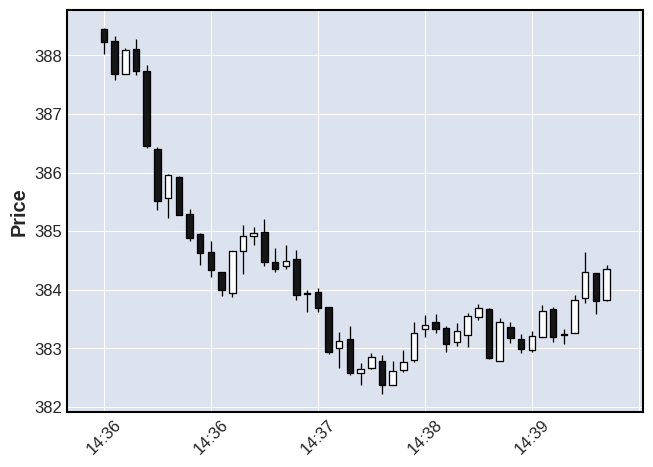

In [35]:
!pip install mplfinance -q
import mplfinance as mpf

df = spy
df.index = pd.DatetimeIndex(df['date'])

mpf.plot(df['2022-11-02 14:36':'2022-11-02 14:39'],type='candle')


In [46]:
spy[50:70]['text']

date
2022-11-02 14:35:25     And we are continuing the process of signific...
2022-11-02 14:35:30                                                  NaN
2022-11-02 14:35:35     With today's action, we've raised interest ra...
2022-11-02 14:35:40     We anticipate that ongoing increases in the t...
2022-11-02 14:35:45                                                  NaN
2022-11-02 14:35:50                                                  NaN
2022-11-02 14:35:55     Financial conditions have tightened significa...
2022-11-02 14:36:00                                                  NaN
2022-11-02 14:36:05     It will take time, however, for the full effe...
2022-11-02 14:36:10     That's why we say in our statement that in de...
2022-11-02 14:36:15                                                  NaN
2022-11-02 14:36:20                                                  NaN
2022-11-02 14:36:25     At some point, as I've said in the last two p...
2022-11-02 14:36:30                           

***Conclusion***

To sum it all up,in this project we have used OpenAI Whisper to transcribe fed speech from a YouTube video. After that we compared and visualized Price Data during the speech in order to identify what part of the speech may have caused market to react significantly.